# RNN with Gater Recurrent Units from scratch

## Import libraries

In [5]:
import csv
import numpy as np
import pickle as pkl
import tensorflow as tf
from random import sample

## Charging data: 

In [6]:
class TextProcess(object):

    def __init__(self):
        self.idx2ch = []
        self.ch2idx = []
    def get_data(self, filename, batch_size=20):
        index = 0
        self.batch_size = batch_size
        with open(filename) as f:
            lines = f.read().split('\n')
            raw_data = '\n'.join(lines)
            self.idx2ch = list(set(raw_data))
            self.ch2idx = { k:v for v,k in enumerate(self.idx2ch) }

        self.n_batches = len(raw_data) // self.batch_size
        # create numpy arrays
        X = np.zeros([self.n_batches, self.batch_size])
        Y = np.zeros([self.n_batches, self.batch_size])
        for i in range(0, self.n_batches):
            X[i] = np.array([ self.ch2idx[ch] for ch in raw_data[i*self.batch_size:(i+1)*self.batch_size] ])
            Y[i] = np.array([ self.ch2idx[ch] for ch in raw_data[(i*self.batch_size) + 1 : ((i+1)*self.batch_size) + 1] ])

        return X.astype(np.int32), Y.astype(np.int32)
    
    def set_parameters(self, batch_size):
        self.batch_size = batch_size
    
    def get_parameters(self):
        return self.n_batches, self.batch_size

## Model definition: 

In [10]:
class rnn_gru(object):
    
    def __init__(self, embedding_size, num_classes):
        self.loss_arr = []
        tf.reset_default_graph()
        self.embedding_size = embedding_size
        self.num_classes = num_classes
        # Placeholders
        xs_ = tf.placeholder(shape=[None, None], dtype=tf.int32)
        ys_ = tf.placeholder(shape=[None], dtype=tf.int32)
        # Initial state of the network
        init_state = tf.placeholder(shape=[None, self.embedding_size], dtype=tf.float32, name='initial_state')
        # Embeddings
        embs = tf.get_variable('emb', [self.num_classes, self.embedding_size])
        rnn_inputs = tf.nn.embedding_lookup(embs, xs_)
        # Initializer
        xav_init = tf.contrib.layers.xavier_initializer
        # Params
        self.W = tf.get_variable('W', shape=[3, self.embedding_size, self.embedding_size], initializer=xav_init())
        self.U = tf.get_variable('U', shape=[3, self.embedding_size, self.embedding_size], initializer=xav_init())
        self.b = tf.get_variable('b', shape=[self.embedding_size], initializer=tf.constant_initializer(0.))
        
        states = tf.scan(self.step, tf.transpose(rnn_inputs, [1,0,2]), initializer=init_state)
        
        # Output
        V = tf.get_variable('V', shape=[self.embedding_size, self.num_classes], initializer=xav_init())
        bo = tf.get_variable('bo', shape=[self.num_classes], initializer=tf.constant_initializer(0.))
        states_reshaped = tf.reshape(states, [-1, self.embedding_size])
        yPredbyNN = tf.matmul(states_reshaped, V) + bo
        predictions = tf.nn.softmax(yPredbyNN)
        
        # get last state
        last_state = states[-1]
        
        # Optimization
 
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = yPredbyNN, labels=ys_)
        loss = tf.reduce_mean(losses)
        train_op = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss)
    
        # Update status
        self.xs_ = xs_
        self.ys_ = ys_
        self.loss = loss
        self.train_op = train_op
        self.predictions = predictions
        self.last_state = last_state
        self.init_state = init_state
    
    def rand_batch_gen(self, x, y, train_batch_size):
        while True:
            sample_idx = sample(list(np.arange(len(x))), train_batch_size)
            yield x[sample_idx], y[sample_idx]
    
    def step(self, st_1, x):
        z = tf.sigmoid(tf.matmul(x,self.U[0]) + tf.matmul(st_1,self.W[0]))
        r = tf.sigmoid(tf.matmul(x,self.U[1]) + tf.matmul(st_1,self.W[1]))
        h = tf.tanh(tf.matmul(x,self.U[2]) + tf.matmul( (r*st_1),self.W[2]))
        st = (1-z)*h + (z*st_1)
        return st
    
    
    def train(self, train_set, epochs=50):
        # training session
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            train_loss = 0
            try:
                for i in range(epochs):
                    for j in range(1000):
                        xs, ys = train_set.__next__()
                        batch_size = xs.shape[0]
                        _, train_loss_ = sess.run([self.train_op, self.loss], feed_dict = {
                                self.xs_ : xs,
                                self.ys_ : ys.flatten(),
                                self.init_state : np.zeros([batch_size, self.embedding_size])
                            })
                        train_loss += train_loss_
                    self.loss_arr.append(train_loss/1000)
                    print('[{}] loss : {}'.format(i,train_loss/1000))
                    train_loss = 0
            except KeyboardInterrupt:
                print('interrupted by user at ' + str(i))


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Display differents graphs using different hyperparameters saved in arrays.
# Input variables are arrays with the same lenght, with the values to graph

def show_graphs(epoch_arr,loss_arr):
# define a list of markevery cases to plot
    cases=[]
    x_values=[]
    y_values=[]
    for i in range(len(epoch_arr)):
        cases.append([epoch_arr[i]])
        # define the data for cartesian plots
        x_values.append(range(epoch_arr[i]))
        y_values.append(loss_arr)
    # define the figure size and grid layout properties
    figsize = (12, 10)
    cols = 2
    gs = gridspec.GridSpec(len(cases) // cols + 1, cols)
    gs.update(hspace=0.4)
    
    fig1 = plt.figure(num=1, figsize=figsize)
    ax = []
    for i, case in enumerate(cases):
        row = (i // cols)
        col = i % cols
        ax.append(fig1.add_subplot(gs[row, col]))
        ax[-1].set_title('Epoch=%s' % (str(case[0])))
        ax[-1].plot(x_values[i], y_values[i], 'o', ls='-', ms=4, markevery=1)

In [12]:
if __name__ == '__main__':
    BATCH_SIZE = 256 
    doc = TextProcess()
    x,y = doc.get_data('data/paulg.txt', 20)
    embedding_size = x.shape[1]
    num_classes = len(doc.idx2ch)
    n_batches, data_batch_size = doc.get_parameters()
    model = rnn_gru(embedding_size, num_classes)
    train_set = model.rand_batch_gen(x,y,BATCH_SIZE)
    model.train(train_set)
    

[0] loss : 3.109379982471466
[1] loss : 3.1043278386592865
[2] loss : 3.1045852324962615
[3] loss : 3.1046839780807494
[4] loss : 3.1041645150184634
[5] loss : 3.1056199281215666
[6] loss : 3.106333283185959
[7] loss : 3.1058114287853242
[8] loss : 3.105020170211792
[9] loss : 3.104790813922882
[10] loss : 3.1063793568611144
[11] loss : 3.1059377274513245
[12] loss : 3.106979667663574
[13] loss : 3.1051918368339537
[14] loss : 3.106333346128464
[15] loss : 3.105849818229675
[16] loss : 3.1069231069087984
[17] loss : 3.119178415298462
[18] loss : 3.107190177679062
[19] loss : 3.1066489140987397
[20] loss : 3.1082334170341492
[21] loss : 3.1067325875759124
[22] loss : 3.1073607823848723
[23] loss : 3.1071897077560426
[24] loss : 3.1079471113681794
[25] loss : 3.1056616983413696
[26] loss : 3.106197536468506
[27] loss : 3.106888318300247
[28] loss : 3.1064909415245054
[29] loss : 3.106295850276947
[30] loss : 3.1065077903270724
[31] loss : 3.107592219352722
[32] loss : 3.107496114015579
[

IndexError: list index out of range

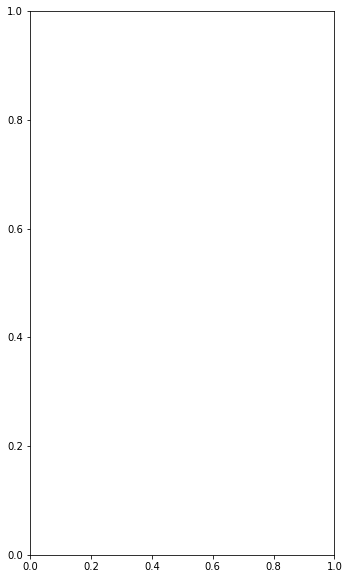

In [14]:
epoch_arr=[]
epoch_arr.append(50)
show_graphs(epoch_arr,model.loss_arr)